In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage.morphology import skeletonize, thin
from skimage.measure import find_contours, approximate_polygon, \
    subdivide_polygon

**TODO**  
- Arreglar Microcystis aeruginosa 1  
- Dibujar el contorno de los gusanitos  
- Probar en imagen conjunta  
- Comentar el código  

**DONE**  
- Descubrir cómo marcar los contornos interiores  
- Comprobar si puedo contar el perímetro del skeleton sin findContours (no lo he necesitado)  
- Restar el área de los contornos interiores  
- Dibujar elipsoide en imagen

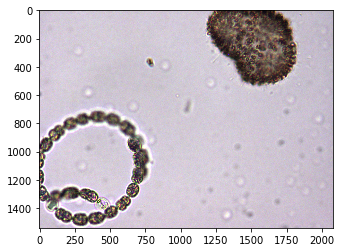

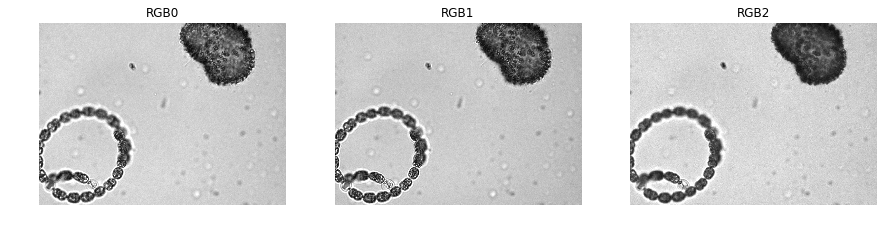

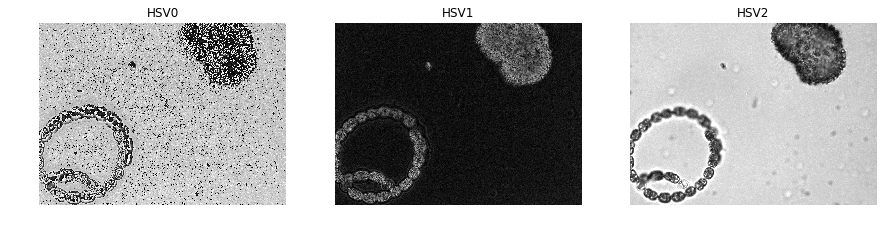

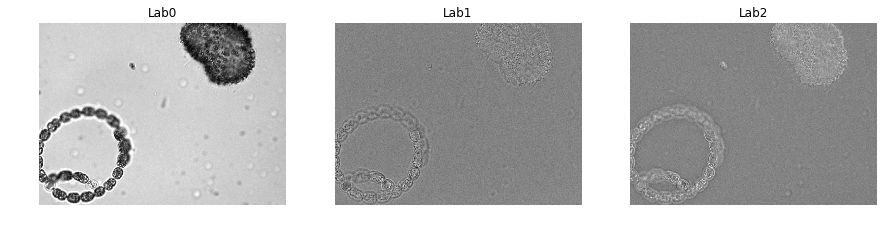

In [18]:
# im = cv2.imread('dataset/Single 40x - Anabaena spiroides 1.jpg')
# im = cv2.imread('dataset/Single 40x - Anabaena spiroides 2.jpg')
# im = cv2.imread('dataset/Single 40x - Anabaena spiroides 3.jpg')
# im = cv2.imread('dataset/Single 40x - Anabaena spiroides 4.jpg')
# im = cv2.imread('dataset/Single 40x - Microcystis aeruginosa 1.jpg')
# im = cv2.imread('dataset/Single 40x - Microcystis aeruginosa 2.jpg')
# im = cv2.imread('dataset/Single 40x - Microcystis aeruginosa 3.jpg')
# im = cv2.imread('dataset/Single 40x - Microcystis aeruginosa 4.jpg')
# im = cv2.imread('dataset/Single 40x - Microcystis flos-aquae 1.jpg')
# im = cv2.imread('dataset/Single 40x - Microcystis flos-aquae 2.jpg')
# im = cv2.imread('dataset/Single 40x - Woronichinia naegeliana 1.jpg')
# im = cv2.imread('dataset/Single 40x - Woronichinia naegeliana 2.jpg')
# im = cv2.imread('dataset/Single 40x - Woronichinia naegeliana 3.jpg')
im = cv2.imread('dataset/Slide 40x 5.jpg')
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)
plt.show()
im_hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
im_lab = cv2.cvtColor(im, cv2.COLOR_BGR2Lab)

images = [im_rgb, im_hsv, im_lab]
names = ['RGB', 'HSV', 'Lab']
for n, img in enumerate(images):
    fig, axeslist = plt.subplots(ncols=3, nrows=1,figsize=(15,15))
    for i in range(3):
        axeslist.ravel()[i].imshow(img[:,:,i], cmap='gray')
        axeslist.ravel()[i].set_title(names[n] + str(i))
        axeslist.ravel()[i].set_axis_off()
    plt.show()

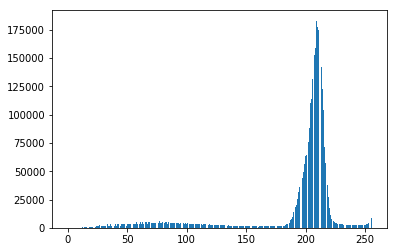

In [19]:
img = im_lab[:,:,0]
# img = 255-im_hsv[:,:,1]
hist, _ = np.histogram(img, 256, [0, 256])
plt.bar(range(0,256), hist)
plt.show()

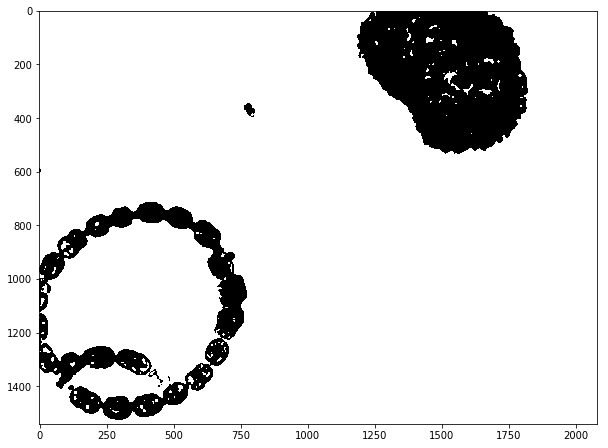

In [20]:
blur = cv2.GaussianBlur(img,(11,11),0)
ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# ret,thresh = cv2.threshold(blur,130,255,0)
plt.figure(figsize=(10,8))
plt.imshow(thresh, cmap='gray')
plt.show()

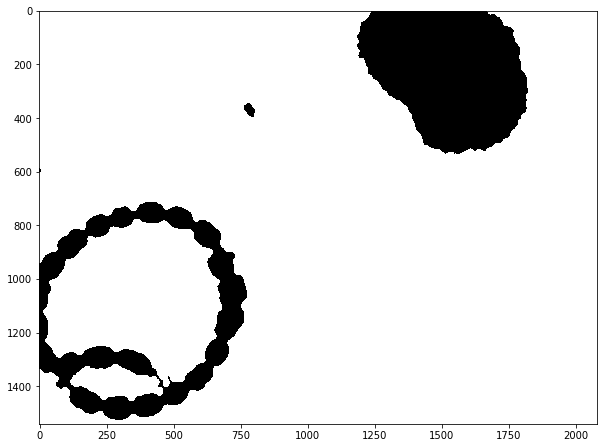

In [21]:
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(40,40))
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25))
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
closing = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(10,8))
plt.imshow(closing, cmap='gray')
plt.show()

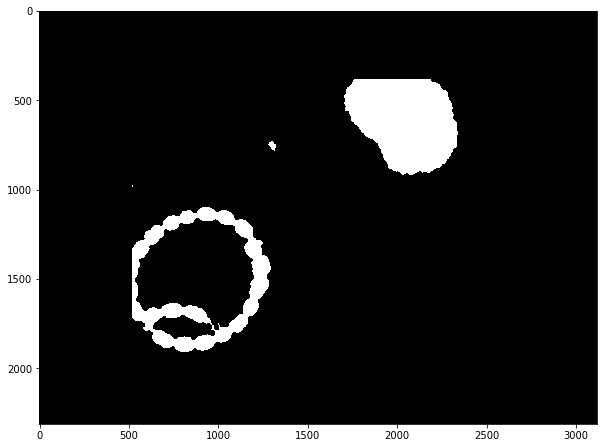

In [69]:
newimage = np.ones((int(closing.shape[0]*1.5), int(closing.shape[1]*1.5))) * 255
newimage[int(closing.shape[0]*0.25):int(closing.shape[0]*1.25), int(closing.shape[1]*0.25):int(closing.shape[1]*1.25)] = closing
plt.figure(figsize=(10,8))
plt.imshow(255-newimage, cmap='gray')
plt.show()

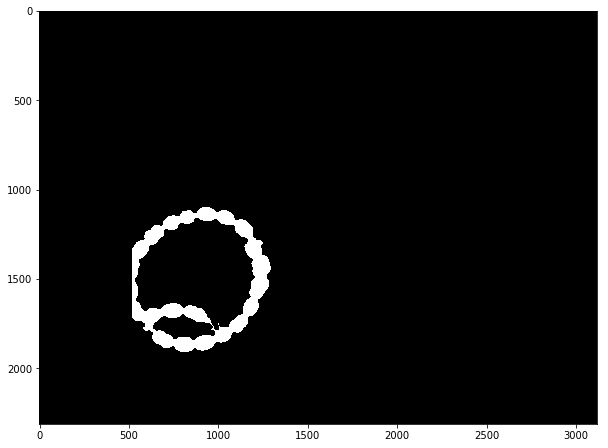

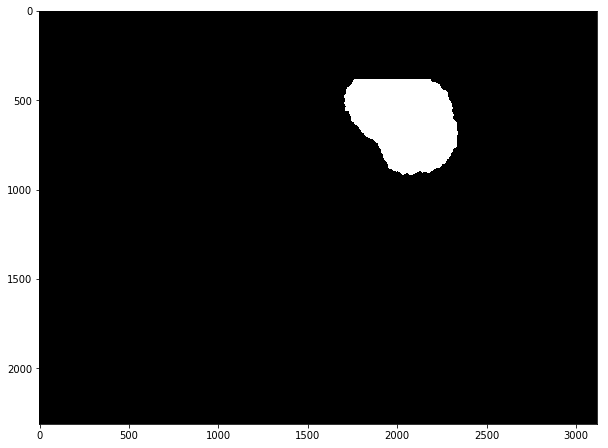

In [102]:
_, contours, hierarchy = cv2.findContours(((255-newimage)/255.0).astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) 
fito = []
areas = []
fito_cont = []
# contours.sort(key=cv2.contourArea, reverse=True)
# mask = np.zeros(newimage.shape,np.uint8)
# cv2.drawContours(mask,contours,0,(255,255,255), thickness=-1, lineType=8, hierarchy=hierarchy, maxLevel=0)
# area = cv2.contourArea(contours[0])

# cv2.drawContours(mask,contours,2,(255,255,255), thickness=-1, lineType=8, hierarchy=hierarchy, maxLevel=0)
for i in range(0,hierarchy.shape[1]):
    if hierarchy[0][i][3] == -1 and cv2.contourArea(contours[i]) > 5000:
        mask = np.zeros(newimage.shape,np.uint8)
        cv2.drawContours(mask,contours,i,(255,255,255), thickness=-1, lineType=8, hierarchy=hierarchy, maxLevel=0)
        fito.append(mask)
        areas.append(cv2.contourArea(contours[i]))
        fito_cont.append(contours[i])
    else:
        mask = fito[hierarchy[0][i][3]]
        cv2.drawContours(mask,contours,i,(0,0,0), thickness=-1, lineType=8, hierarchy=hierarchy, maxLevel=0)
        fito[hierarchy[0][i][3]] = mask
        area = areas[hierarchy[0][i][3]]
        areas[hierarchy[0][i][3]] = areas[hierarchy[0][i][3]] - cv2.contourArea(contours[i])

for mask in fito:
    plt.figure(figsize=(10,8))
    plt.imshow(mask, cmap='gray')
    plt.show()

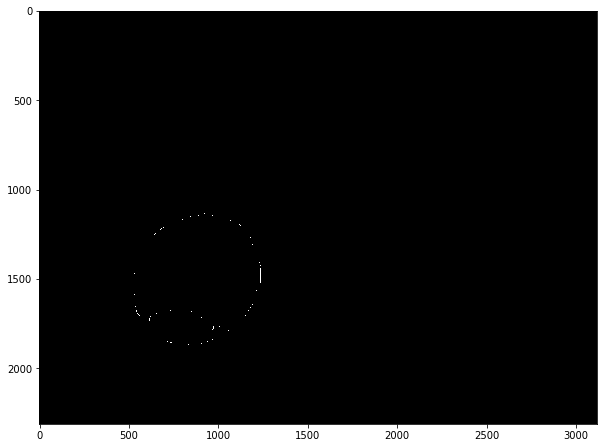

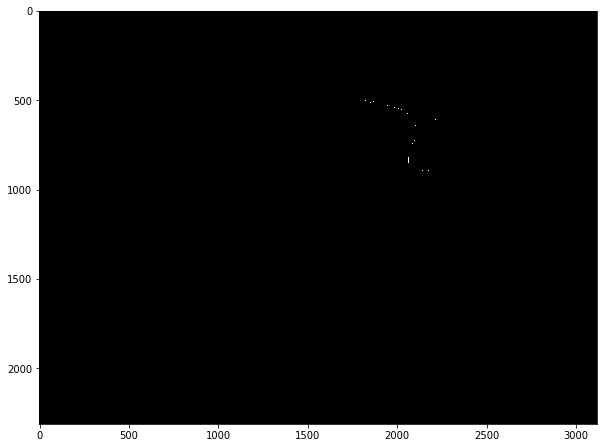

In [103]:
skeletons = []
# perform skeletonization
for mask in fito:
    skeleton = skeletonize(mask/255)
    skeletons.append(skeleton)
    plt.figure(figsize=(10,8))
    plt.imshow(skeleton, cmap='gray',interpolation="nearest")
    plt.show()

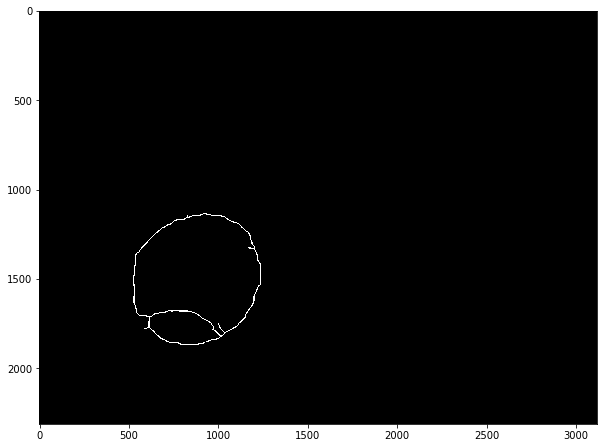

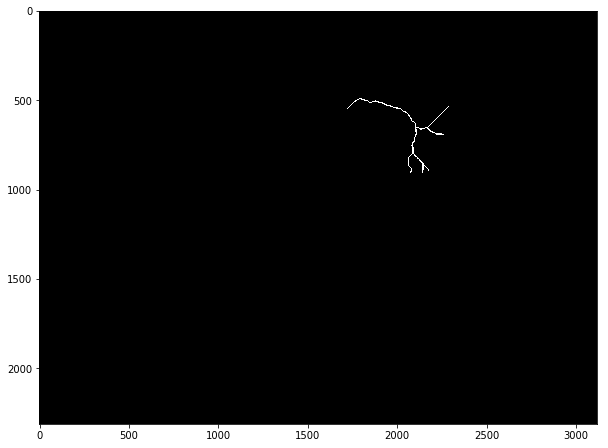

In [104]:
perimeters = []
skelemasks = []
for skeleton in skeletons:
    _, contours, hierarchy = cv2.findContours(skeleton.astype(int),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
#     contours.sort(key=lambda c: cv2.arcLength(c, False), reverse=True)
    perimeter = 0
    for c in contours:
        perimeter += cv2.arcLength(c,False)
    skelemask = np.zeros(skeleton.shape,np.uint8)
    cv2.drawContours(skelemask,contours,-1,(255,255,255), thickness=3, lineType=8, hierarchy=hierarchy)
    perimeters.append(perimeter)
    skelemasks.append(skelemask)
    plt.figure(figsize=(10,8))
    plt.imshow(skelemask, cmap='gray')
    plt.show()

In [105]:
nonspiro = []
for i,f in enumerate(fito):
    area = areas[i]
    perimeter = perimeters[i]
    ratio = perimeter/area
    if ratio > 0.073:
        width = area/perimeter
        volume = np.pi * (width/2)*(width/2) * perimeter
        print('---------------------------------------')
        print('Fito {}:'.format(i))
        print('Area = {:0.2f}, Perimeter = {:0.2f}'.format(area, perimeter))
        print('Mean width = {:0.2f}'.format(width))
        print('Volume = {:0.2f}'.format(volume))
        print('Ratio Perimeter/Area = {:0.4f}'.format(ratio))
        print('---------------------------------------')
    else:
        nonspiro.append(i)

---------------------------------------
Fito 0:
Area = 168889.50, Perimeter = 12417.82
Mean width = 13.60
Volume = 1804055.37
Ratio Perimeter/Area = 0.0735
---------------------------------------


(2023.5, 653.0) (635.0, 536.0) -0.0
---------------------------------------
Fito 1:
Area = 253105.50, Perimeter = 2108.74
Mean width = 120.03
Volume = 95521674.48
Ratio Perimeter/Area = 0.0083
---------------------------------------


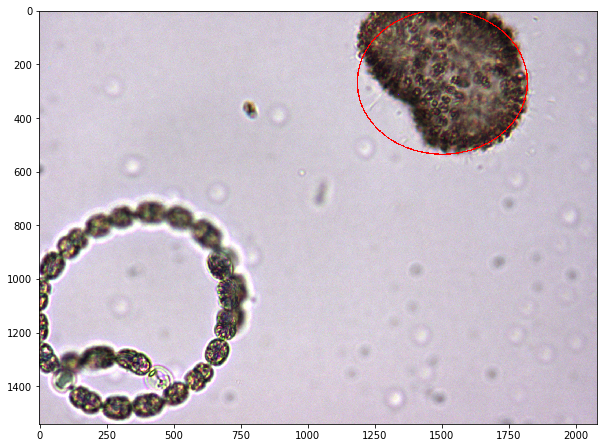

In [106]:
for n in nonspiro:
    mask = fito[n]
    contours = [fito_cont[n]]
#     _, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) 
#     contours.sort(key=cv2.contourArea, reverse=True)
    mask = np.zeros(mask.shape,np.uint8)
#     cv2.drawContours(mask,contours,0,(255,255,255), thickness=-1, lineType=8, hierarchy=hierarchy, maxLevel=0)
    cv2.drawContours(mask,contours,0,(255,255,255), thickness=-1, lineType=8)
    fito[n] = mask
    area = cv2.contourArea(contours[0])
    perimeter = cv2.arcLength(contours[0],False)
    areas[n] = area
    perimeters[n] = perimeter
    ratio = perimeter/area
    width = area/perimeter
    ((x,y),(w,h), angle) = cv2.minAreaRect(contours[0])
    print((x,y),(w,h), angle)
    a = max(w,h)/2
    b = min(w,h)/2
    volume = (4/3)*np.pi*a*b*b
    print('---------------------------------------')
    print('Fito {}:'.format(n))
    print('Area = {:0.2f}, Perimeter = {:0.2f}'.format(area,perimeter))
    print('Mean width = {:0.2f}'.format(width))
    print('Volume = {:0.2f}'.format(volume))
    print('Ratio Perimeter/Area = {:0.4f}'.format(ratio))
    print('---------------------------------------')
    x = int(x - closing.shape[1]*0.25)
    y = int(y - closing.shape[0]*0.25)
    cv2.ellipse(im_rgb,(int(x),int(y)),(int(w/2),int(h/2)),int(angle),0,360,(255, 0, 0),3)
    plt.figure(figsize=(10,8))
    plt.imshow(im_rgb)
    plt.show()

-------

dataset/Slide 40x 5
---------------------------------------
Fito 0:
Species: spiroides detected
Area = 168889.50, Perimeter = 12417.82
Mean width = 13.60
Volume = 1804055.37
Ratio Perimeter/Area = 0.0735
---------------------------------------
---------------------------------------
Fito 1:
Species: non-spiroides detected
Area = 253105.50, Perimeter = 2108.74
Mean width = 120.03
Volume = 95521674.48
Ratio Perimeter/Area = 0.0083
---------------------------------------


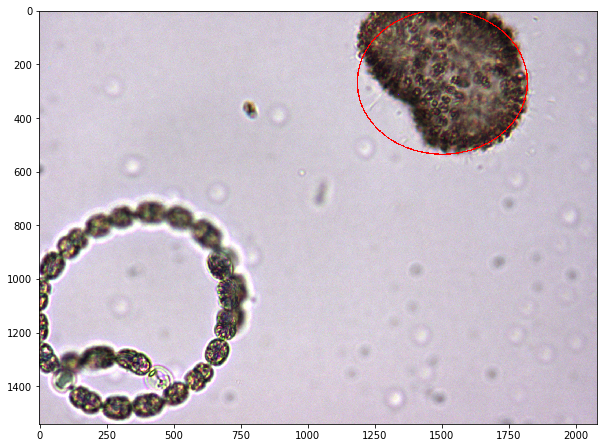

In [107]:
# names = ['dataset/Single 40x - Anabaena spiroides 1.jpg',
#          'dataset/Single 40x - Anabaena spiroides 2.jpg',
#          'dataset/Single 40x - Anabaena spiroides 3.jpg',
#          'dataset/Single 40x - Anabaena spiroides 4.jpg',
#          'dataset/Single 40x - Anabaena spiroides 5.jpg',
#          'dataset/Single 40x - Woronichinia naegeliana 1.jpg',
#          'dataset/Single 40x - Woronichinia naegeliana 2.jpg',
#          'dataset/Single 40x - Woronichinia naegeliana 3.jpg',
#          'dataset/Single 40x - Woronichinia naegeliana 4.jpg',
#          'dataset/Single 40x - Woronichinia naegeliana 5.jpg',
#          'dataset/Single 40x - Woronichinia naegeliana 6.jpg',
#          'dataset/Single 40x - Microcystis aeruginosa 1.jpg',
#          'dataset/Single 40x - Microcystis aeruginosa 2.jpg',
#          'dataset/Single 40x - Microcystis aeruginosa 3.jpg',
#          'dataset/Single 40x - Microcystis aeruginosa 4.jpg',
#          'dataset/Single 40x - Microcystis flos-aquae 1.jpg',
#          'dataset/Single 40x - Microcystis flos-aquae 2.jpg']

# names = ['dataset/Single 40x - Woronichinia naegeliana 1.jpg',
#          'dataset/Single 40x - Woronichinia naegeliana 2.jpg',
#          'dataset/Single 40x - Woronichinia naegeliana 3.jpg',
#          'dataset/Single 40x - Woronichinia naegeliana 4.jpg',
#          'dataset/Single 40x - Woronichinia naegeliana 5.jpg',
#          'dataset/Single 40x - Woronichinia naegeliana 6.jpg',
#          'dataset/Single 40x - Microcystis aeruginosa 1.jpg',
#          'dataset/Single 40x - Microcystis aeruginosa 2.jpg',
#          'dataset/Single 40x - Microcystis aeruginosa 3.jpg',
#          'dataset/Single 40x - Microcystis aeruginosa 4.jpg',
#          'dataset/Single 40x - Microcystis flos-aquae 1.jpg',
#          'dataset/Single 40x - Microcystis flos-aquae 2.jpg']

names = ['dataset/Slide 40x 5.jpg']

save = False

for image_name in names:
    short_name = image_name.split('- ')[-1].split('.jpg')[0]
    im = cv2.imread(image_name)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    im_lab = cv2.cvtColor(im, cv2.COLOR_BGR2Lab)

    img = im_lab[:,:,0]
    blur = cv2.GaussianBlur(img,(11,11),0)
#     ret,thresh = cv2.threshold(blur,160,255,0) cambiado a:
    ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25))
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(40,40))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    newimage = np.ones((int(closing.shape[0]*1.5), int(closing.shape[1]*1.5))) * 255
    newimage[int(closing.shape[0]*0.25):int(closing.shape[0]*1.25), int(closing.shape[1]*0.25):int(closing.shape[1]*1.25)] = closing

    fito = []
    areas = []
    fito_cont = []
    _, contours, hierarchy = cv2.findContours(((255-newimage)/255.0).astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) 
    for i in range(0,hierarchy.shape[1]):
        if hierarchy[0][i][3] == -1 and cv2.contourArea(contours[i]) > 5000:
            mask = np.zeros(newimage.shape,np.uint8)
            cv2.drawContours(mask,contours,i,(255,255,255), thickness=-1, lineType=8, hierarchy=hierarchy, maxLevel=0)
            fito.append(mask)
            areas.append(cv2.contourArea(contours[i]))
            fito_cont.append(contours[i])
        else:
            mask = fito[hierarchy[0][i][3]]
            cv2.drawContours(mask,contours,i,(0,0,0), thickness=-1, lineType=8, hierarchy=hierarchy, maxLevel=0)
            fito[hierarchy[0][i][3]] = mask
            area = areas[hierarchy[0][i][3]]
            areas[hierarchy[0][i][3]] = areas[hierarchy[0][i][3]] - cv2.contourArea(contours[i])

    skeletons = []
    for mask in fito:
        skeleton = skeletonize(mask/255)
        skeletons.append(skeleton)
    
    perimeters = []
    skelemasks = []
    for skeleton in skeletons:
        _, contours, hierarchy = cv2.findContours(skeleton.astype(int),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
        perimeter = 0
        for c in contours:
            perimeter += cv2.arcLength(c,False)
        skelemask = np.zeros(skeleton.shape,np.uint8)
        cv2.drawContours(skelemask,contours,-1,(255,255,255), thickness=3, lineType=8, hierarchy=hierarchy)
        perimeters.append(perimeter)
        skelemasks.append(skelemask)
        width = area/perimeter
        volume = np.pi * (width/2)*(width/2) * perimeter
        ratio = perimeter/area
    
    print('=======================================')
    print(short_name)
    if save:
        cv2.imwrite('{}.png'.format(short_name),im)
    nonspiro = []
    for i,mask in enumerate(fito):
        area = areas[i]
        perimeter = perimeters[i]
        ratio = perimeter/area
        if ratio > 0.073:
            width = area/perimeter
            volume = np.pi * (width/2)*(width/2) * perimeter
            print('---------------------------------------')
            print('Fito {}:'.format(i))
            print('Species: spiroides detected')
            print('Area = {:0.2f}, Perimeter = {:0.2f}'.format(area, perimeter))
            print('Mean width = {:0.2f}'.format(width))
            print('Volume = {:0.2f}'.format(volume))
            print('Ratio Perimeter/Area = {:0.4f}'.format(ratio))
            print('---------------------------------------')
            if save:
                orig_mask = mask[int(closing.shape[0]*0.25):int(closing.shape[0]*1.25), int(closing.shape[1]*0.25):int(closing.shape[1]*1.25)]
                cv2.imwrite('{}-{}-area.png'.format(short_name,i),orig_mask)
                orig_skelemask = skelemask[int(closing.shape[0]*0.25):int(closing.shape[0]*1.25), int(closing.shape[1]*0.25):int(closing.shape[1]*1.25)]
                cv2.imwrite('{}-{}-skelemask.png'.format(short_name,i),orig_skelemask)
        else:
            nonspiro.append(i)
    
    for n in nonspiro:
        mask = fito[n]
        contours = [fito_cont[n]]
#         _, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) 
#         contours.sort(key=cv2.contourArea, reverse=True)
#         mask = np.zeros(mask.shape,np.uint8)
#         cv2.drawContours(mask,contours,0,(255,255,255), thickness=-1, lineType=8, hierarchy=hierarchy, maxLevel=0)
        cv2.drawContours(mask,contours,0,(255,255,255), thickness=-1, lineType=8)
        fito[n] = mask
        area = cv2.contourArea(contours[0])
        perimeter = cv2.arcLength(contours[0],False)
        areas[n] = area
        perimeters[n] = perimeter
        ratio = perimeter/area
        width = area/perimeter
        ((x,y),(w,h), angle) = cv2.minAreaRect(contours[0])
        a = max(w,h)/2
        b = min(w,h)/2
        volume = (4/3)*np.pi*a*b*b
        print('---------------------------------------')
        print('Fito {}:'.format(n))
        print('Species: non-spiroides detected')
        print('Area = {:0.2f}, Perimeter = {:0.2f}'.format(area,perimeter))
        print('Mean width = {:0.2f}'.format(width))
        print('Volume = {:0.2f}'.format(volume))
        print('Ratio Perimeter/Area = {:0.4f}'.format(ratio))
        print('---------------------------------------')
        x = int(x - closing.shape[1]*0.25)
        y = int(y - closing.shape[0]*0.25)
        cv2.ellipse(im_rgb,(int(x),int(y)),(int(w/2),int(h/2)),int(angle),0,360,(255, 0, 0),3)
        if save:
            orig_mask = newmask[int(closing.shape[0]*0.25):int(closing.shape[0]*1.25), int(closing.shape[1]*0.25):int(closing.shape[1]*1.25)]
            cv2.imwrite('{}-{}-area.png'.format(short_name,n),orig_mask)
    plt.figure(figsize=(10,8))
    plt.imshow(im_rgb)
    plt.show()
    print('=======================================')
    
